<a href="https://colab.research.google.com/github/jannat99/ML/blob/main/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a> <br>
# Imports and Dataset

In [ ]:
# Data preprocessing
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Deep learning
from tensorflow.python import keras
from keras import backend as K
import tensorflow as tf 
from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop




<a id="2"></a> <br>
# Preparing Data for CNN

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/My Drive/COVID-19_Radiography_Dataset/'

os.listdir(DATASET_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['COVID.metadata.xlsx',
 'Lung_Opacity.metadata.xlsx',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia.metadata.xlsx',
 'COVID',
 'Lung_Opacity',
 'Normal',
 'Viral Pneumonia']

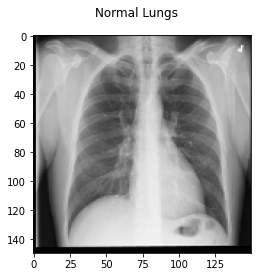

In [ ]:
normal_images = []
count = 0

for img_path in glob.glob(DATASET_DIR + "/Normal/*"):
    count += 1
    normal_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
    if count > 230:
        break
    
fig = plt.figure()
fig.suptitle("Normal Lungs")
plt.imshow(normal_images[0], cmap="gray")
plt.show()

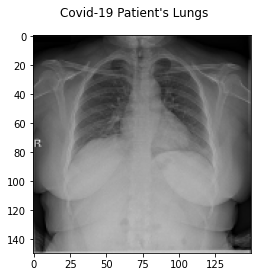

In [ ]:
covid_images = []
for img_path in glob.glob(DATASET_DIR + "/COVID/*"): 
    covid_images.append(image.load_img(str(img_path), target_size = (150,150,3)))
    
fig = plt.figure()
fig.suptitle("Covid-19 Patient's Lungs ")
plt.imshow(covid_images[0], cmap = "gray")
plt.show()

In [ ]:
print(str(len(normal_images))+" normal patient images")
print(str(len(covid_images))+" covid patient images")

231 normal patient images
3616 covid patient images


In [ ]:
images_together = []

for i in normal_images:
    images_together.append(img_to_array(i))
    
for i in covid_images:
    images_together.append(img_to_array(i))
    
targets = np.zeros(len(images_together))
targets[:len(normal_images)-1] = 1 # normal-> 1, covid-19-> 0

In [ ]:
print("image list length: ",len(images_together))
print("target list length: ",len(targets))

image list length:  3847
target list length:  3847


In [ ]:
targets = np.array(targets)
print("targets: ",targets.shape)
targets = targets.reshape(-1,1)
print("new shape of targets: ",targets.shape)

targets:  (3847,)
new shape of targets:  (3847, 1)


In [ ]:
images_together = np.array(images_together)
print("shape of images together: ",images_together.shape)

shape of images together:  (3847, 150, 150, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images_together, targets, test_size=0.25, stratify=targets)

images_together = np.concatenate((X_train, X_val))
targets = np.concatenate((y_train, y_val))

<a id="3"></a> <br>
# CNN Model

In [ ]:
IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 32
BATCH_SIZE = 40

* **Our model's diagram:**
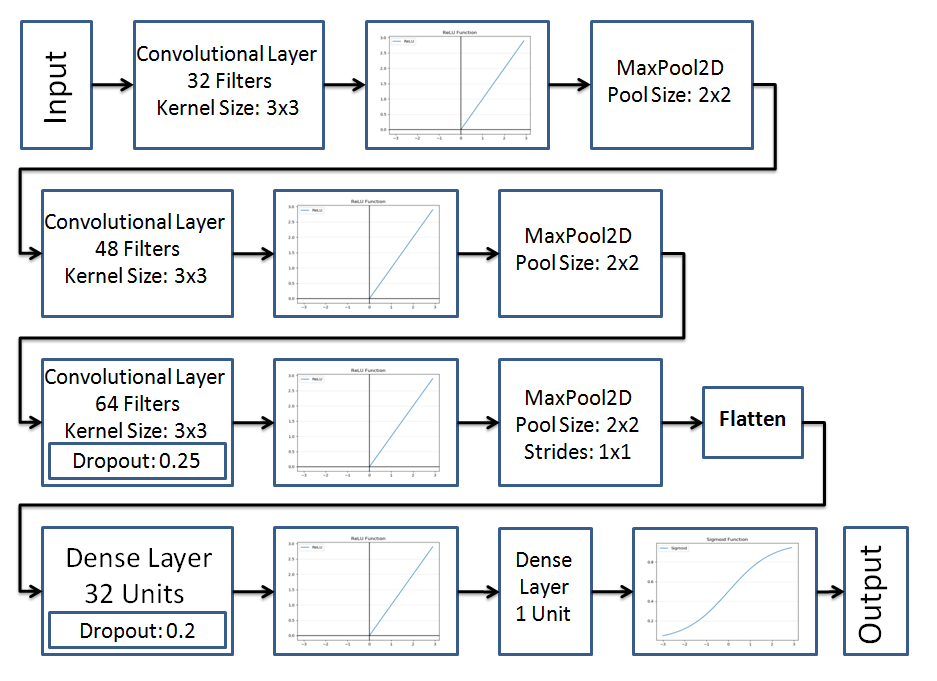

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = INPUT_SHAPE, activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 48, kernel_size = (3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

# compile 
model.compile(loss = "binary_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 48)        13872     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        27712     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 33, 33, 64)       0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)


train_generator = train_datagen.flow(
images_together, targets,
batch_size = BATCH_SIZE,
subset = "training")

validation_generator = train_datagen.flow(
images_together, targets,
batch_size = BATCH_SIZE,
shuffle = False,
subset = "validation")

#fitting
hist = model.fit_generator(
train_generator,
steps_per_epoch = (450*0.75)//BATCH_SIZE,
validation_data = validation_generator,
validation_steps = (450*0.25)// BATCH_SIZE,
epochs = EPOCHS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/32
8/8 [==============================] - 12s 1s/step - loss: 0.5048 - accuracy: 0.8813 - val_loss: 0.2266 - val_accuracy: 0.9375
Epoch 2/32
8/8 [==============================] - 14s 2s/step - loss: 0.3207 - accuracy: 0.9219 - val_loss: 0.2588 - val_accuracy: 0.9375
Epoch 3/32
8/8 [==============================] - 10s 1s/step - loss: 0.2167 - accuracy: 0.9545 - val_loss: 0.2206 - val_accuracy: 0.9375
Epoch 4/32
8/8 [==============================] - 11s 1s/step - loss: 0.2425 - accuracy: 0.9500 - val_loss: 0.2511 - val_accuracy: 0.9375
Epoch 5/32
8/8 [==============================] - 11s 1s/step - loss: 0.2453 - accuracy: 0.9438 - val_loss: 0.2788 - val_accuracy: 0.9375
Epoch 6/32
8/8 [==============================] - 11s 1s/step - loss: 0.2298 - accuracy: 0.9438 - val_loss: 0.2216 - val_accuracy: 0.9375
Epoch 7/32
8/8 [==============================] - 12s 1s/step - loss: 0.1947 - accuracy: 0.9531 - val_loss: 0.3600 - val_accuracy: 0.9375
Epoch 8/32
8/8 [==================

<a id="3.1"></a> <br>
## Results

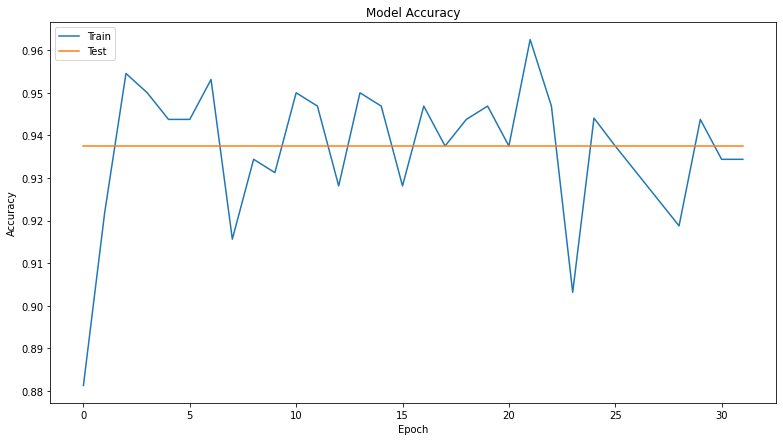

In [ ]:
plt.figure(figsize = (13,7))
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
#plt.text(23,0.5,"Current Training Accuracy: "+str(np.round(hist.history["accuracy"][-1]*100,2))+"%",fontsize = 18,color = "black")
#plt.text(23,0.46,"Current Validation Accuracy: "+str(np.round(hist.history["val_accuracy"][-1]*100,2))+"%",fontsize = 18,color = "black")
plt.show()

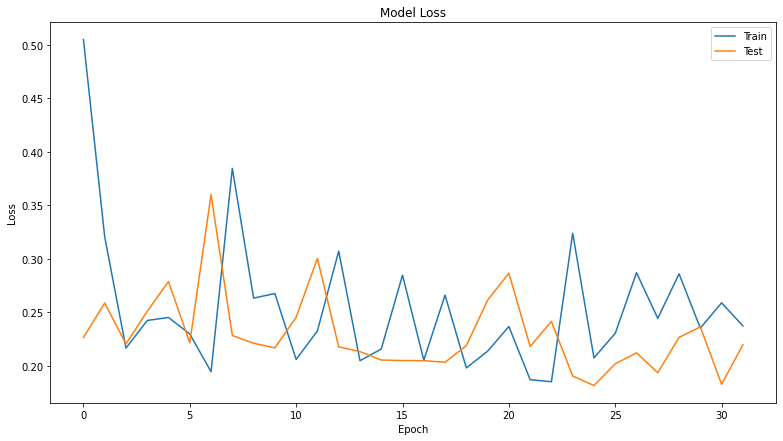

In [ ]:
plt.figure(figsize = (13,7))
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper right")
#plt.text(26,0.8,"Current Training Loss: "+str(np.round(hist.history["loss"][-1],3)),fontsize = 18,color = "black")
#plt.text(26,0.73,"Current Validation Loss: "+str(np.round(hist.history["val_loss"][-1],3)),fontsize = 18,color = "black")
plt.show()

In [ ]:
print("Training Accuracy: "+str(np.round(hist.history["accuracy"][-1]*100,2))+"%")
print("Validation Accuracy: "+str(np.round(hist.history["val_accuracy"][-1]*100,2))+"%")

Training Accuracy: 93.44%
Validation Accuracy: 93.75%
